# 1-hour Machine learning automation

# Fabdev (my company)
Python for platforms, tools, data analysis, machine learning.  
http://fabdev.fr

In [62]:
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Data taken from Kaggle.com
https://www.kaggle.com/ludobenistant/hr-analytics

# Part 1 : Data visualisation

In [63]:
df = pd.read_csv('HR_comma_sep.csv')

In [64]:
print(df.shape)
df.head()

(14999, 10)


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [65]:
df.salary.replace({'low':1,'medium':2,'high':3},inplace=True)

In [66]:
left = df[df['left'] == 1].sample(frac=1)
stayed = df[df['left'] == 0].sample(frac=0.35)
df = pd.concat([left,stayed])
df['left'].value_counts()

0    4000
1    3571
Name: left, dtype: int64

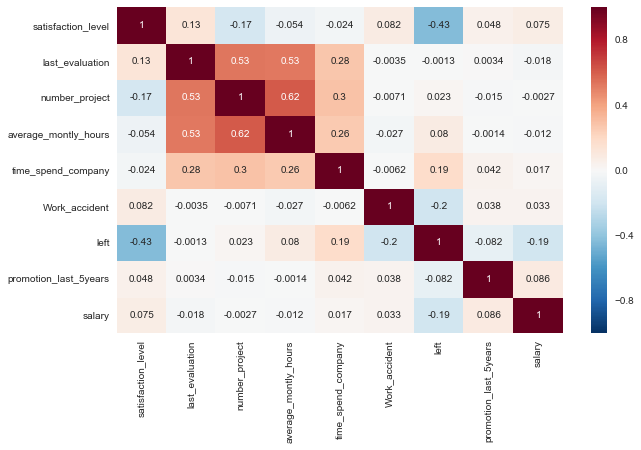

In [67]:
corr = df.corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr,annot=True)

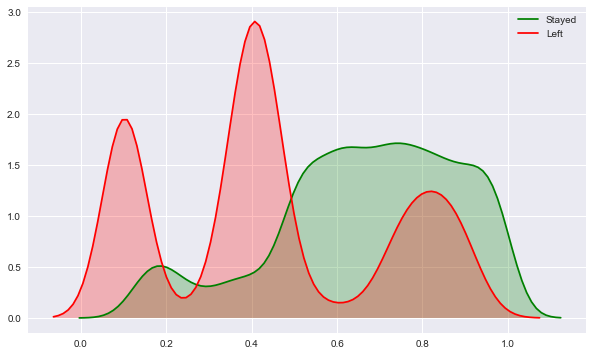

In [68]:
plt.figure(figsize=(10,6))
sns.kdeplot(df[df['left'] == 0]['satisfaction_level'], color='g',shade=True, label='Stayed')
sns.kdeplot(df[df['left'] == 1]['satisfaction_level'], color='r',shade=True, label='Left')

People who have left were in general less satisfied with their jobs (<0.5).  
However there are also people who are quite satisfied with their jobs but still left.  
This means that there are other factors contributing to an employee leaving their job other than them being satisfied with their job or not. 

In [69]:
unhappy = df[df['satisfaction_level']<0.5]
happy = df[0.5<df['satisfaction_level']]

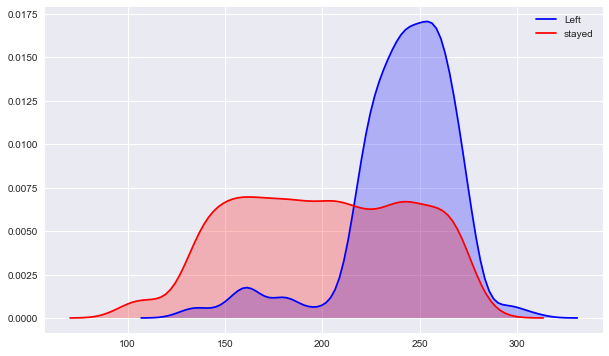

In [70]:
plt.figure(figsize=(10,6))
sns.kdeplot(happy[happy['left']==1]['average_montly_hours'], color = 'b', shade=True)
sns.kdeplot(happy[happy['left']==0]['average_montly_hours'], color = 'r', shade=True)
plt.legend(['Left','stayed'])

Many more dataviz analysis could be done like so, but we only have one hour so let's keep going.

# Part 2 : Machine learning
We will start with an easy to visualise algorithm : **the decision tree**.   
Unlike many other machine learning algorithms, decision trees require very little data preparation (no feature scaling or centering).  
Normally we should have done a Part 0 : Data cleaning & preparation

### Split the data for training and testing

In [71]:
X = df[['satisfaction_level','average_montly_hours','promotion_last_5years','salary','number_project']]
y = df['left']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0,test_size=0.25)
print('Training set volume:', X_train.shape[0])
print('Test set volume:', X_test.shape[0])

Training set volume: 5678
Test set volume: 1893


### Train a simple decision tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(min_samples_split=25,max_depth=3)
tree_clf.fit(X_train, y_train)
predicts_dt = tree_clf.predict(X_test)
print("Accuracy score : %f" % accuracy_score(y_test, predicts_dt))

85 % of predictions on the test dataset were right.

!['HR tree'](./hr_tree3.png)

A node’s **samples** attribute counts how many training instances it applies to.   
A node’s **value** attribute tells you how many training instances of each class this node applies to.  
A node’s **gini** attribute measures its impurity: a node is “pure” (gini=0) if all training instances it applies to belong to the same class.  
For example for left leaf : 
$$1 − \frac{25}{1162}^2 − \frac{1137}{1162}^2 ≈ 0.0421$$

### Train a bigger decision tree

In [75]:
big_tree_clf = DecisionTreeClassifier(min_samples_split=25,max_depth=15)
big_tree_clf.fit(X_train, y_train)
predicts_dt = big_tree_clf.predict(X_test)
print("Accuracy score : %f" % accuracy_score(y_test, predicts_dt))

Accuracy score : 0.911252


!['HR heavy tree'](./big_hr_tree3.png)

### The CART training algorithm  

Scikit-Learn uses the Classication And Regression Tree (CART) algorithm to train Decision Trees.  
The idea is really quite simple: the algorithm first splits the training set in two subsets using a single feature k and a threshold tk (eg. “satisfaction level ≤ 0.4”). 
Then it searches for the pair k, tk that produces the purest subsets (weighted by their size).  
The cost function that the algorithm tries to minimize is given by :
$$ J(k,t_{k})   = \frac{m_{left}*G_{left}}{m}  + \frac{m_{right}*G_{right}}{m} $$
Where $G_{left}$ measures the impurity of the left subset.  
$m_{left}$ is the number of instances in the left subset.  
Once it has successfully split the training set in two, it splits the subsets using the same logic, then the sub-subsets and so on, recursively. It stops recursing once it reaches the maximum depth (defined by the max_depth hyperparameter), or if it cannot find a split that will reduce impurity.



# Random forest

A random forest algorithm is an ensemble of Decision Tree classifiers, each trained on a random subset of the training dataset.   
To make predictions, you just obtain the predictions of all individual trees, then predict the class that gets the most votes.   
Despite its simplicity, this is one of the most powerful Machine Learning algorithms available today thanks to the law of large numbers.

In [74]:
#Random forest classifier
clf_rf = RandomForestClassifier(n_estimators = 10,min_samples_split=2,max_depth=30)
clf_rf.fit(X_train, y_train)

accuracy_rf = clf_rf.score(X_test,y_test)
print("Accuracy score : %f" % accuracy_rf)

Accuracy score : 0.940306


In [ ]:
X_test.head(5)

In [ ]:
clf_rf.predict(X_test.head(5))

In [ ]:
y_test.head(5)

## Training on all available data and exporting the model for later use

In [76]:
clf_rf = RandomForestClassifier(n_estimators = 10,min_samples_split=2,max_depth=30)
clf_rf.fit(X, y)
from sklearn.externals import joblib
joblib.dump(clf_rf, 'rf_model.pkl')

['rf_model.pkl']

In [ ]:
df.head()

# Starting an automation tool with flask